In [ ]:
import dataclasses
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import wandb
import warnings

from datetime import datetime
from sklearn.model_selection import KFold
from fastprogress import progress_bar

from fos import seminmf_full as seminmf

warnings.filterwarnings("ignore")

In [1]:
WANDB_PROJECT = "serotonin-fos-seminmf-counts+intensity"
RESULTS_DIR = os.path.join("..", "results", datetime.now().strftime("%Y_%m_%d-%H_%M"))

if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

## Combine all the per-mouse arrays into one file

In [2]:
# DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"

# N = len(os.listdir(DATA_DIREC))
# height = 89
# width = 95
# depth = 80
# intensity_3d = np.zeros((N, height, width, depth), dtype=np.float32)
# counts_3d = np.zeros((N, height, width, depth), dtype=np.int16)
# inds = -1 * np.ones(N)

# for i, fname in enumerate(os.listdir(DATA_DIREC)):
#     # print(fname)
#     ind = int(fname[:3])
#     inds[i] = ind

#     npz = np.load(os.path.join(DATA_DIREC, fname))
#     coords = npz["coords"]
#     x, y, z = coords.T
#     intensity_3d[i][x, y, z] = npz["log_vs"]
#     counts_3d[i][x, y, z] = npz["Ns"]
    
# np.savez(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"),
#          intensity=intensity_3d, counts=counts_3d, mouse_inds=inds)

## Load the combined data

In [3]:
!ls -lh /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz

-rw-rw----+ 1 swl1 swl1 655M Nov  1 17:44 /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz


In [4]:
DATA_FILE = "/scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz"
data = np.load(DATA_FILE)
intensity_3d = data["intensity"][:-1]
counts_3d = data["counts"][:-1]
mouse_inds = data["mouse_inds"]
assert intensity_3d.shape[0] == 168
assert counts_3d.shape[0] == 168

In [5]:
DRUG_FILE = "/scratch/groups/swl1/serotonin/drug_ids.npy"
drugs = np.load(DRUG_FILE)

### Remove the left edge to address edge effects

In [6]:
LEFT_TRUNC = 8
counts_3d = counts_3d[:, LEFT_TRUNC:, :, :]
intensity_3d = intensity_3d[:, LEFT_TRUNC:, :, :]
counts_3d.shape

(168, 81, 95, 80)

### Only work with live voxels

In [7]:
alive_voxels = jnp.sum(counts_3d, axis=0) > 0
print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")

348766 / 615600 voxels are 'alive'


In [8]:
intensity = intensity_3d[:, alive_voxels]
counts = counts_3d[:, alive_voxels]
intensity[counts == 0] = 0.0

(<Axes: >, <matplotlib.image.AxesImage at 0x7f5068458e20>)

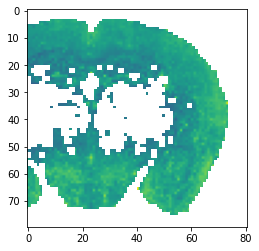

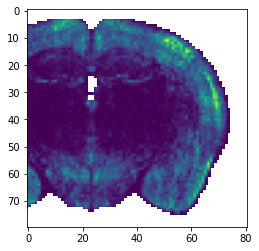

In [9]:
def plot_coronal(flat_array, y_idx, ax=None):
    arr = jnp.nan * jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(flat_array)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T)
    return ax, im

vis_intensity = jnp.where(counts == 0, jnp.nan, intensity)

plot_coronal(vis_intensity[100], 50)

plot_coronal(counts[100], 50)

### Make random masks

Mask off hyperrectangles for each mouse.

In [10]:
# def make_masks(key, size, num_rect_per_mouse=3):
MASK_KEY = 0
MASK_SIZE = 10
NUM_MASKS_PER_MOUSE = 3

key = jr.PRNGKey(MASK_KEY)
M, H, W, D = counts_3d.shape
masks_3d = jnp.ones_like(counts_3d, dtype=bool)

for m in progress_bar(range(M)):
    for i in range(NUM_MASKS_PER_MOUSE):
        k1, k2, k3, key = jr.split(key, 4)
        x,y,z = jr.randint(k1, (3,), minval=jnp.zeros(3), maxval=jnp.array([H, W, D]))
        masks_3d = masks_3d.at[m, x:x+MASK_SIZE, y:y+MASK_SIZE, z:z+MASK_SIZE].set(False)

masks = masks_3d[:, alive_voxels]


(<Axes: >, <matplotlib.image.AxesImage at 0x7f50143e56a0>)

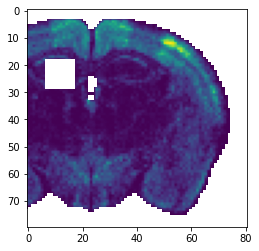

In [11]:
plot_coronal(jnp.where(masks[0], counts[0], jnp.nan), 50)

## Select hyperparameters by cross validation

In [33]:
mean_func = "softplus"
elastic_net_frac = 1.0
num_iters = 500
num_coord_ascent_iters = 1

# Compute the SVD initialization once
max_num_factors = 24
full_initial_params = seminmf.initialize_nnsvd(counts, intensity, max_num_factors, mean_func, drugs=None)

# Fit the model
all_sparsity_penalties = jnp.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
all_num_factors = jnp.arange(2, max_num_factors+1, 2)
# all_sparsity_penalties = jnp.array([1e-2])
# all_num_factors = jnp.array([18])
all_heldout_loglikes = -jnp.inf * jnp.ones((len(all_sparsity_penalties), len(all_num_factors)))

for i, sparsity_penalty in enumerate(all_sparsity_penalties):
    for j, num_factors in enumerate(all_num_factors):
        wandb.init(
            # set the wandb project where this run will be logged
            project=WANDB_PROJECT,
            job_type="train",

            # track hyperparameters and run metadata
            config={
                "sparsity_penalty": sparsity_penalty,
                "num_factors": num_factors,
                "elastic_net_frac": elastic_net_frac,
                "max_num_iters": num_iters,
                "num_coord_ascent_iters": num_coord_ascent_iters,
                "mean_func": mean_func,
                "initialization": "nnsvd",
                "data_file": DATA_FILE,
                "drug_file": DRUG_FILE,
                "left_trunc": LEFT_TRUNC,
                "mask_key": MASK_KEY,
                "mask_size": MASK_SIZE,
                "num_mask_per_mouse": NUM_MASKS_PER_MOUSE,
                }
        )
        
        print("fitting model with", sparsity_penalty, "sparsity and ", num_factors, "factors")
        initial_params = dataclasses.replace(
            full_initial_params,
            factors=full_initial_params.factors[:num_factors],
            count_loadings=full_initial_params.count_loadings[:, :num_factors],
            intensity_loadings=full_initial_params.intensity_loadings[:, :num_factors],
        )

        params, losses, heldout_loglikes = \
            seminmf.fit_poisson_seminmf(counts,
                                intensity,
                                initial_params,
                                mask=masks,
                                mean_func=mean_func,
                                sparsity_penalty=sparsity_penalty,
                                elastic_net_frac=elastic_net_frac,
                                num_iters=num_iters,
                                num_coord_ascent_iters=num_coord_ascent_iters,
                                tolerance=1e-5
                                )

        all_heldout_loglikes = all_heldout_loglikes.at[i, j].set(heldout_loglikes[-1])
        
        # Log results to wandb
        wandb.run.summary["final_loss"] = losses[-1]
        wandb.run.summary["heldout_loglike"] = heldout_loglikes[-1]
        wandb.finish()


NameError: name 'wandb' is not defined

## Evaluate the best fitting model

In [ ]:
istar, jstar = jnp.unravel_index(jnp.argmax(all_heldout_loglikes), all_heldout_loglikes.shape)
best_sparsity_penalty = all_sparsity_penalties[istar]
best_num_factors = all_num_factors[jstar]
print("Optimal sparsity penalty:", best_sparsity_penalty)
print("Optimal number of factors:", best_num_factors)

In [13]:
# Initialize a new wandb run
eval_run = wandb.init(
    project=WANDB_PROJECT,
    job_type="eval",
    config={
        "sparsity_penalty": best_sparsity_penalty,
        "num_factors": best_num_factors,
        "elastic_net_frac": elastic_net_frac,
        "max_num_iters": num_iters,
        "num_coord_ascent_iters": num_coord_ascent_iters,
        "mean_func": mean_func,
        "initialization": "nnsvd",
        "data_file": DATA_FILE,
        "drug_file": DRUG_FILE,
        "left_trunc": LEFT_TRUNC,
        "mask_key": MASK_KEY,
        "mask_size": MASK_SIZE,
        "num_mask_per_mouse": NUM_MASKS_PER_MOUSE,
        }
)

Optimal sparsity penalty: 0.01
Optimal number of factors: 14


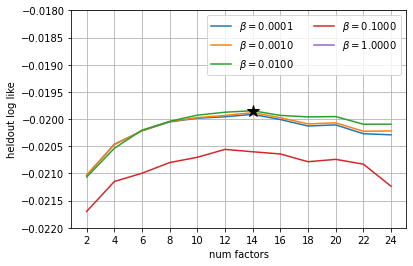

In [14]:
for j, sparsity_penalty in enumerate(all_sparsity_penalties):
    plt.plot(all_num_factors, all_heldout_loglikes[j], label=r"$\beta={:.4f}$".format(sparsity_penalty))
plt.plot(best_num_factors, all_heldout_loglikes[istar, jstar], 'k*', ms=12)
plt.xticks(all_num_factors)
plt.grid(True)
plt.xlabel("num factors")
plt.ylabel("heldout log like")
plt.ylim(-0.022, -0.018)
plt.legend(ncols=2)
plt.savefig(os.path.join(RESULTS_DIR, "cross_val.png"))

wandb.log({"cross_val": wandb.Image(os.path.join(RESULTS_DIR, "cross_val.png"))})

## Fit model with a chosen number of factors on all data

In [15]:
initial_params = seminmf.initialize_nnsvd(counts, intensity, best_num_factors, mean_func, drugs=None)

In [16]:
sparsity_penalty = 1e-2
elastic_net_frac = 1.0
num_iters = 500
num_coord_ascent_iters = 1

print("fitting model with", best_num_factors, "factors")
params, losses, heldout_loglikes = \
    seminmf.fit_poisson_seminmf(counts,
                        intensity,
                        initial_params,
                        mask=None,
                        mean_func=mean_func,
                        sparsity_penalty=best_sparsity_penalty,
                        elastic_net_frac=elastic_net_frac,
                        num_iters=num_iters,
                        num_coord_ascent_iters=num_coord_ascent_iters,
                        tolerance=1e-5
                        )

# Log results to wandb
wandb.run.summary["final_loss"] = losses[-1]

fitting model with 14 factors


Text(0, 0.5, 'loss')

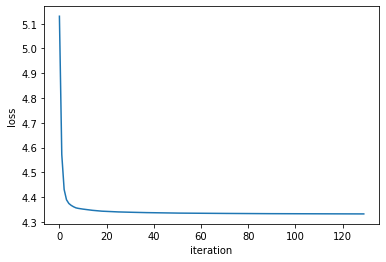

In [17]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

plt.savefig(os.path.join(RESULTS_DIR, "train_loss.png"))
wandb.log({"traing_loss": wandb.Image(os.path.join(RESULTS_DIR, "train_loss.png"))})

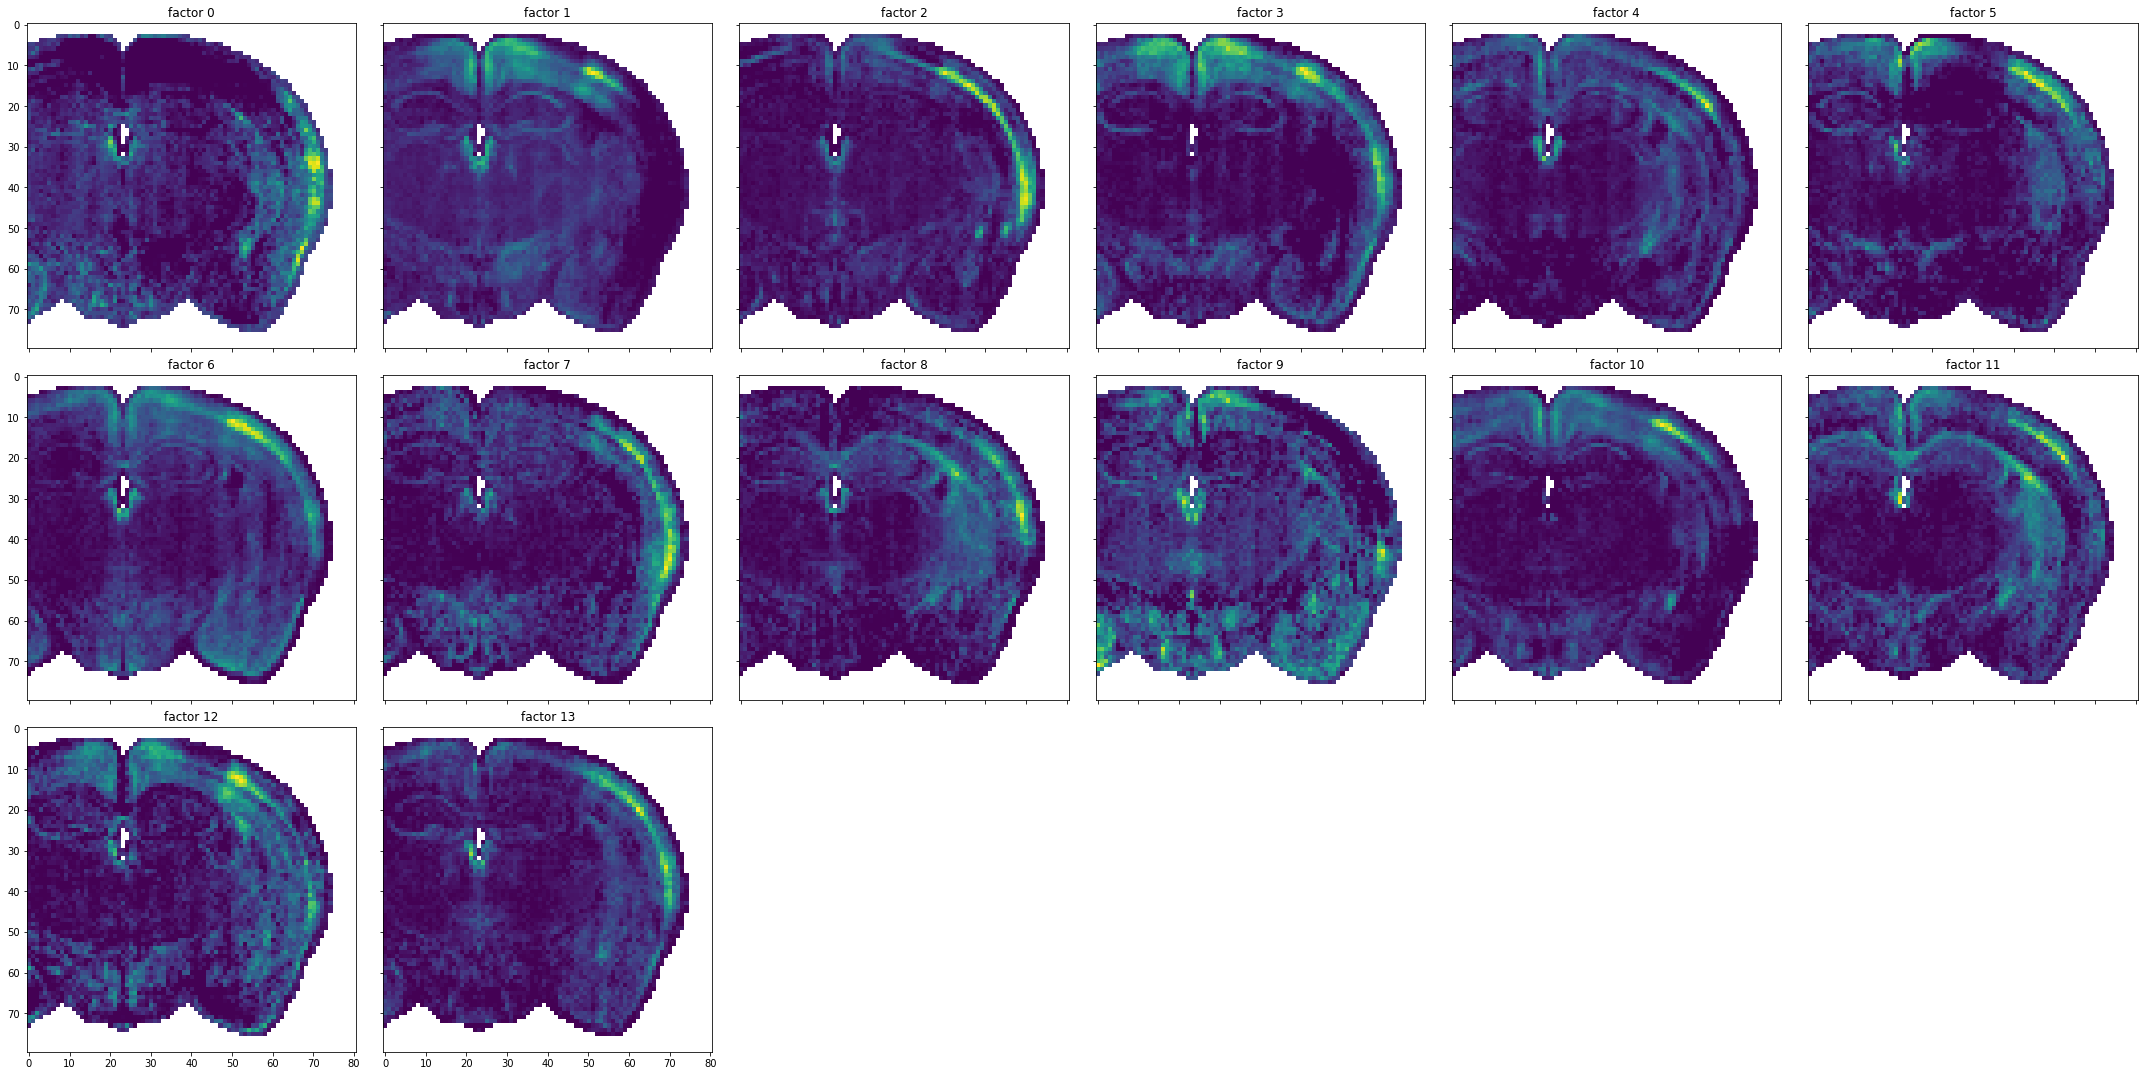

In [18]:
fig, axs = plt.subplots(3, 6, figsize=(30, 15), sharey=True, sharex=True)
for k, ax in enumerate(axs.ravel()):
    if k < best_num_factors:
        plot_coronal(params.factors[k], y_idx=50, ax=ax)
        ax.set_title("factor {}".format(k))
    else:
        ax.set_visible(False)
        
plt.tight_layout()

plt.savefig(os.path.join(RESULTS_DIR, "factors.png"), dpi=300)
wandb.log({"factors": wandb.Image(os.path.join(RESULTS_DIR, "factors.png"))})

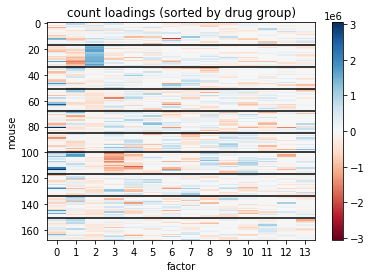

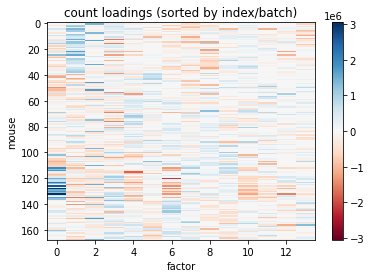

In [19]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.count_loadings
vmax = abs(loadings).max()

plt.figure()
plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by drug group)")
plt.colorbar()
plt.savefig(os.path.join(RESULTS_DIR, "count_loadings_by_drug.png"), dpi=300)
wandb.log({"count_loadings_by_drug": wandb.Image(os.path.join(RESULTS_DIR, "count_loadings_by_drug.png"))})

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("count loadings (sorted by index/batch)")
plt.colorbar()

plt.savefig(os.path.join(RESULTS_DIR, "count_loadings_by_batch.png"), dpi=300)
wandb.log({"count_loadings_by_batch": wandb.Image(os.path.join(RESULTS_DIR, "count_loadings_by_batch.png"))})


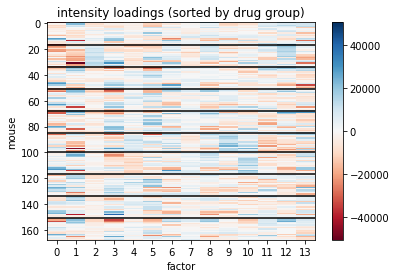

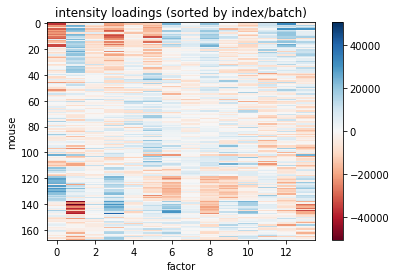

In [20]:
perm = jnp.argsort(drugs)
bounds = jnp.cumsum(jnp.bincount(drugs)[1:-1])

loadings = params.intensity_loadings
vmax = abs(loadings).max()

plt.figure()
plt.imshow(loadings[perm], vmin=-vmax, vmax=vmax, cmap="RdBu", aspect="auto", interpolation="none")
for bound in bounds:
    plt.axhline(bound, color='k')
_ = plt.xticks(np.arange(best_num_factors))

plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by drug group)")
plt.colorbar()
plt.savefig(os.path.join(RESULTS_DIR, "intensity_loadings_by_drug.png"), dpi=300)
wandb.log({"intensity_loadings_by_drug": wandb.Image(os.path.join(RESULTS_DIR, "intensity_loadings_by_drug.png"))})

plt.figure()
plt.imshow(loadings, aspect="auto", cmap="RdBu", vmin=-vmax, vmax=vmax, interpolation="none")
plt.xlabel("factor")
plt.ylabel("mouse")
plt.title("intensity loadings (sorted by index/batch)")
plt.colorbar()
plt.savefig(os.path.join(RESULTS_DIR, "intensity_loadings_by_batch.png"), dpi=300)
wandb.log({"intensity_loadings_by_batch": wandb.Image(os.path.join(RESULTS_DIR, "intensity_loadings_by_batch.png"))})

## Check downstream drug classification

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# normalize weights and factors
def normalize_weights(weights):
    U = weights
    U = U - U.mean()
    U /= U.std()
    return(U)

def downstream_task(W, drugs, **kwargs):
    """
    kwargs
    ------
    cv: pass in the same CV splitter for both the grid search and the confusion matrix
    """
#     W_norm = normalize_weights(W)
    W_norm = W
    parameters = {"C":10 ** np.linspace(-15,15,num=31)}
    lr = LogisticRegression()
    gridsearch = GridSearchCV(lr, parameters, **kwargs)
    gridsearch.fit(W_norm, drugs)
    drug_clf_acc = gridsearch.best_score_
    classifier = gridsearch.best_estimator_
    drugs_pred = cross_val_predict(classifier, W_norm, y=drugs, **kwargs)
    confusion_mat = confusion_matrix(drugs, drugs_pred)
    return(classifier, drug_clf_acc, confusion_mat)

0.49376114081996436


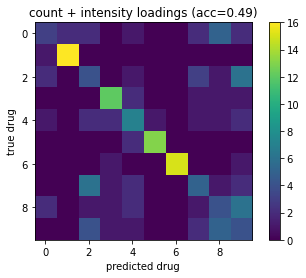

In [22]:
features = jnp.hstack([normalize_weights(params.count_loadings),
                       normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)

print(acc)
wandb.run.summary["count+intensity drug acc"] = acc


plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count + intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

plt.savefig(os.path.join(RESULTS_DIR, "count_intensity_confmat.png"), dpi=300)
wandb.log({"count_intensity_confmat": wandb.Image(os.path.join(RESULTS_DIR, "count_intensity_confmat.png"))})

0.5183600713012477


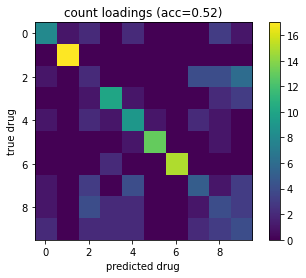

In [23]:
features = jnp.hstack([normalize_weights(params.count_loadings),
#                        normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)
print(acc)
wandb.run.summary["count drug acc"] = acc

plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("count loadings (acc={:.2f})".format(acc))
plt.colorbar()

plt.savefig(os.path.join(RESULTS_DIR, "count_confmat.png"), dpi=300)
wandb.log({"count_confmat": wandb.Image(os.path.join(RESULTS_DIR, "count_confmat.png"))})


0.4636363636363637


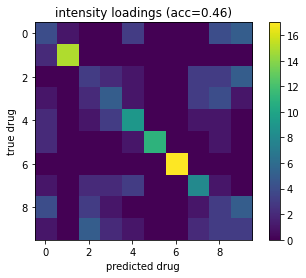

In [24]:
features = jnp.hstack([normalize_weights(params.intensity_loadings),
                      ])
cv = KFold(shuffle=True, random_state=0)
clf, acc, cmat = downstream_task(features, drugs, cv=cv)
print(acc)
wandb.run.summary["intensity drug acc"] = acc

plt.imshow(cmat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.title("intensity loadings (acc={:.2f})".format(acc))
plt.colorbar()

plt.savefig(os.path.join(RESULTS_DIR, "intensity_confmat.png"), dpi=300)
wandb.log({"intensity_confmat": wandb.Image(os.path.join(RESULTS_DIR, "intensity_confmat.png"))})


### Inferred intensity variance for each voxel

Text(0.5, 1.0, 'estimated intensity variance')

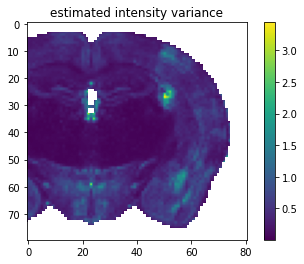

In [25]:
ax, im = plot_coronal(params.intensity_variance, 50)
plt.colorbar(im)
ax.set_title("estimated intensity variance")

plt.savefig(os.path.join(RESULTS_DIR, "intensity_variance.png"), dpi=300)
wandb.log({"intensity_variance": wandb.Image(os.path.join(RESULTS_DIR, "intensity_variance.png"))})

Text(0.5, 1.0, 'average weight per voxel')

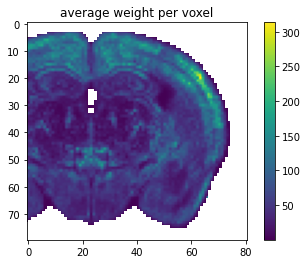

In [26]:
ax, im = plot_coronal((counts.mean(axis=0)) / params.intensity_variance, 50)
# im.set_clim(0, 1)
plt.colorbar(im)
ax.set_title("average weight per voxel")

plt.savefig(os.path.join(RESULTS_DIR, "avg_voxel_weight.png"), dpi=300)
wandb.log({"avg_voxel_weight": wandb.Image(os.path.join(RESULTS_DIR, "avg_voxel_weight.png"))})

## Sort factors by decoding importance

### Single feature decoding

In [27]:
from fastprogress.fastprogress import master_bar, progress_bar

accs = -jnp.inf * jnp.ones(best_num_factors)
for j in progress_bar(range(best_num_factors)):
    features = jnp.column_stack([params.count_loadings[:,j:j+1],
                                 params.intensity_loadings[:,j:j+1]])
    features = normalize_weights(features)
    cv = KFold(shuffle=True, random_state=0)
    _, acc, _ = downstream_task(features, drugs, cv=cv)
    accs = accs.at[j].set(acc)

factor_perm = jnp.argsort(accs)[::-1]
factor_perm

wandb.run.summary["factor_perm_single"] = str(factor_perm)

Array([ 2,  4,  7,  9,  3,  1, 12,  0, 10, 11,  5,  8, 13,  6], dtype=int32)

### Greedy Forward
Use a greedy forward procedure where we build up the model one feature at a time, adding the feature that most improves the classification accuracy. Intuitively, we expect this approach to yield an ordering that is similar to the norm of the weights of the full decoder, but that's not strictly guaranteed.

In [28]:
from fastprogress.fastprogress import master_bar, progress_bar

indices = jnp.array([], dtype=int)

mb = master_bar(range(best_num_factors))        
for i in mb:
    accs = -jnp.inf * jnp.ones(best_num_factors)
    for j in progress_bar(range(best_num_factors), parent=mb):
        if j not in indices:
            features = jnp.column_stack([params.count_loadings[:,indices],
                                         params.intensity_loadings[:,indices],
                                         params.count_loadings[:,j],
                                         params.intensity_loadings[:,j],
                                        ])
            features = normalize_weights(features)
            cv = KFold(shuffle=True, random_state=0)
            _, acc, _ = downstream_task(features, drugs, cv=cv)
            accs = accs.at[j].set(acc)
            
    best_j = jnp.argmax(accs)
    indices = jnp.insert(indices, 0, best_j)

factor_perm = indices[::-1]    
factor_perm

wandb.run.summary["factor_perm_greedyforward"] = str(factor_perm)

Array([ 2,  7,  1,  9,  6, 10, 12,  3, 11,  5,  0,  8, 13,  4], dtype=int32)

### Leave one out accuracy

How much does performance drop when we leave out one feature?

In [29]:
# loo_acc = []

# for k in progress_bar(range(best_num_factors)):
    
#     features = jnp.hstack([params.count_loadings[:,:k],
#                            params.count_loadings[:,k+1:]])
#     features = normalize_weights(features)
#     cv = KFold(shuffle=True, random_state=0)
#     _, acc, _ = downstream_task(features, drugs, cv=cv)
#     loo_acc.append(acc)
    
# loo_acc = jnp.array(loo_acc)
# factor_perm = jnp.argsort(loo_acc)

In [30]:
# features = normalize_weights(params.count_loadings)
# cv = KFold(shuffle=True, random_state=0)
# _, full_acc, _ = downstream_task(features, drugs, cv=cv)
# plt.bar(jnp.arange(best_num_factors), full_acc - loo_acc)

## Save factors to Python and matlab files

In [43]:
import pickle
with open(os.path.join(RESULTS_DIR, "params.pkl"), 'wb') as f:
    pickle.dump(params, f)

artifact = wandb.Artifact(name="params_pkl", type="model")
artifact.add_dir(local_path=os.path.join(RESULTS_DIR, "params.pkl"))
eval_run.log_artifact(artifact)

In [51]:
from scipy.io import savemat
import numpy as onp
savemat(os.path.join(RESULTS_DIR, "params.mat"),
       dict(factors=onp.array(params.factors),
            count_loadings=onp.array(params.count_loadings),
            count_row_effects=onp.array(params.count_row_effects),
            count_col_effects=onp.array(params.count_col_effects),
            intensity_loadings=onp.array(params.intensity_loadings),
            intensity_row_effects=onp.array(params.intensity_row_effects),
            intensity_col_effects=onp.array(params.intensity_col_effects),
            intensity_variance=onp.array(params.intensity_variance))
       )

artifact = wandb.Artifact(name="params_mat", type="model")
artifact.add_dir(local_path=os.path.join(RESULTS_DIR, "params.mat"))
eval_run.log_artifact(artifact)

In [52]:
# from scipy.io import loadmat
# params_mat = loadmat(os.path.join(RESULTS_DIR, "params.mat"))

## Save factors to tiff stack

In [31]:
from tifffile import imsave

def save_factor(factor, filename):
    arr = jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(factor)
    arr = jnp.transpose(arr, (1, 2, 0))
    arr /= arr.max()
    imsave(filename, arr)
    
for k, factor in enumerate(params.factors):
    fname = os.path.join(RESULTS_DIR, "factor{}.tif".format(k))
    save_factor(factor, fname)
    
    artifact = wandb.Artifact(name="factor{}.tif".format(k), type="tif")
    artifact.add_dir(local_path=fname)
    eval_run.log_artifact(artifact)

### Finish the WANDB Run

In [ ]:
wandb.finish()